# Comparing conventional and approximate Single-Output GPs training time and loss over number of samples

In [2]:
import math
import time
import gc
import logging
from itertools import product
import os.path

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

DATA_PATH = "temp/time_over_sample_nb_single.csv"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'}.")

Training on NVIDIA GeForce RTX 3080.


### Define Models
- Gaussian Likelihood
- Zero Mean

In [2]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ApproxGPModel15(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel15, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=15)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ApproxGPModel5(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel5, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = famgpytorch.kernels.RBFKernelApprox(number_of_eigenvalues=5)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Set up helper functions used to repeat training and measure time

In [3]:
def train_gp(model_type, nb_training_points):
    train_x = torch.linspace(0, 1, nb_training_points, device=device)
    train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04)

    likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
    model = model_type(train_x, train_y, likelihood)
    model.to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    torch.cuda.synchronize()

    try:
        start = time.perf_counter()
        for i in range(50):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
        end = time.perf_counter()
    except (torch.cuda.OutOfMemoryError, RuntimeError) as e:
        logging.error(repr(e)[:140] + "...")
        return None, None, nb_training_points

    return end-start, -mll(model(train_x), train_y).item(), None

def eval_gp(model, likelihood, nb_test_points):
    test_x = torch.linspace(0, 1, nb_test_points, device=device)

    model.eval()
    likelihood.eval()

    start = time.perf_counter()
    with torch.no_grad():
        observed_pred = likelihood(model(test_x))
    end = time.perf_counter()

    return observed_pred, end-start

def repeat_train(model_types, training_sample_nbs, truncate_file=False):

    training_times = np.empty(len(model_types), dtype=float)
    training_losses = np.empty(len(model_types), dtype=float)

    failed = set()
    marked = set()

    for train_sample_nb in training_sample_nbs:
        for row, model_type in enumerate(model_types):
            if model_type in failed:
                # skip already failed models
                training_times[row], training_losses[row] = None, None
                continue
            
            # Make sure everything unnecessary is deleted from memory
            gc.collect()
            torch.cuda.empty_cache()

            if model_type not in marked:
                training_times[row], training_losses[row], failed_sample_nb = train_gp(
                    model_type, nb_training_points=train_sample_nb
                )
                if training_times[row] > 1800:
                    # training took > 1800s -> mark to fail in next iteration
                    marked.add(model_type)
            else:
                training_times[row], training_losses[row], failed_sample_nb = None, None, train_sample_nb

            if failed_sample_nb:
                failed.add(model_type)
                print(f"{model_type.__name__} failed at {failed_sample_nb} data points.")
                if set(model_types).issubset(failed):
                    # break after all models failed
                    break
        else:
            # training did not fail for at least one model, write data
            if not os.path.isfile(DATA_PATH) or truncate_file:
                # create / truncate file and add headers
                with open(DATA_PATH, "w") as f:
                    f.write(
                        "sample_nbs," +
                        ",".join([name + "_" + suffix for name, suffix in product(
                            [m.__name__.lower() for m in model_types],
                            ["train_time", "train_nll"]
                        )])
                    )
                truncate_file = False
            with open(DATA_PATH, "a", encoding="utf-8") as f:
                f.write(f"\n{train_sample_nb}," + ",".join([f"{a},{b}" for a, b in zip(training_times, training_losses)]))

            continue
        # training did fail for all models, break out
        break

### Repeat the training for models and plot data

In [4]:
sample_nbs = np.arange(2000, 100001, 2000)
repeat_train([ConventionalGPModel, ApproxGPModel15, ApproxGPModel5], sample_nbs, truncate_file=True)

C:\Users\pasca\Documents\Studienarbeit\PythonProject\.venv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
ERROR:root:OutOfMemoryError('CUDA out of memory. Tried to allocate 6.57 GiB. GPU 0 has a total capacity of 10.00 GiB of which 0 bytes is free. Of the a...


ConventionalGPModel failed at 42000 data points.


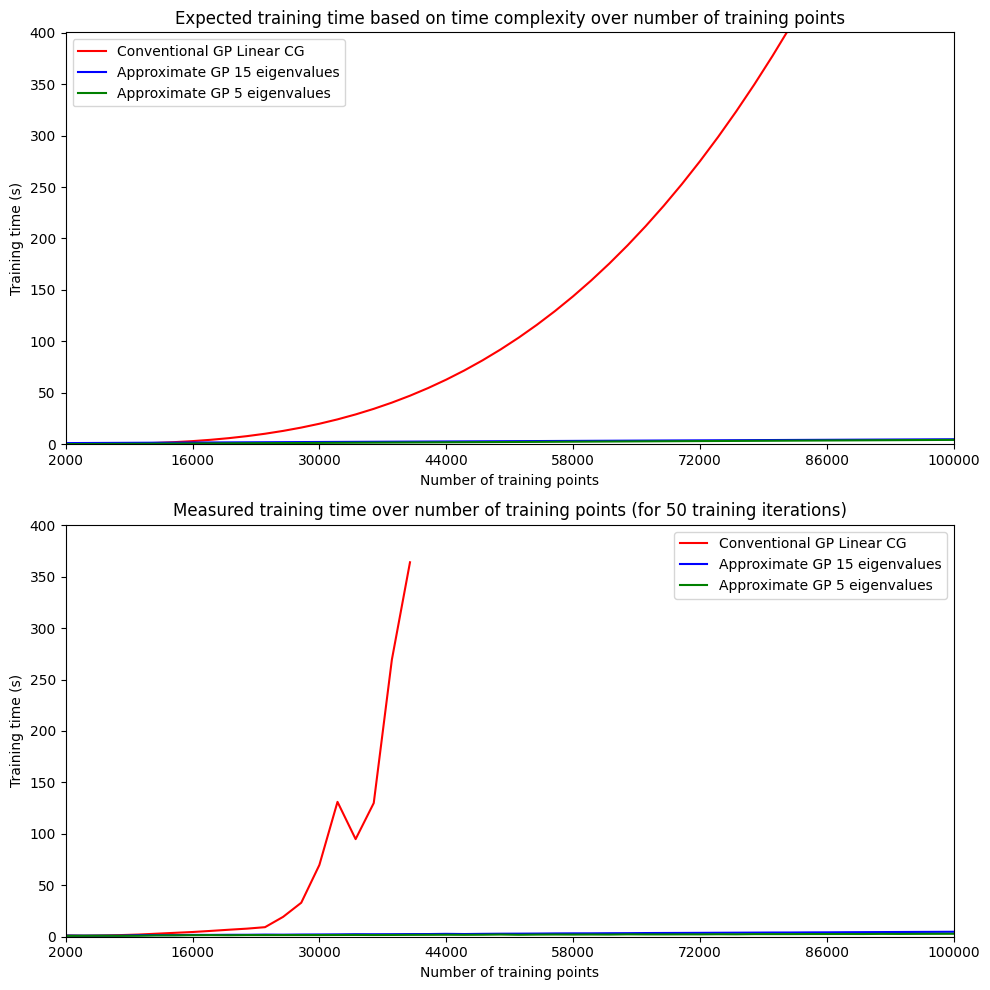

In [3]:
with open(DATA_PATH, "r", encoding="utf-8") as f:
    line_count = len(f.readlines()) - 1
    f.seek(0)
    headers = f.readline()  # discard headers

    sample_nbs = np.empty(line_count, dtype=int)
    train_t = np.empty((len(headers.split(",")[1:])//2, line_count), dtype=float)
    train_l = np.empty((len(headers.split(",")[1:])//2, line_count), dtype=float)
    col = 0
    while line := f.readline():
        data = line.split(',')
        sample_nbs[col] = data[0]

        for row, v in enumerate(data[1:]):
            if row % 2 == 0:
                train_t[row // 2, col] = v
            else:
                train_l[row // 2, col] = v

        col += 1

# plot results
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = np.nanmax(train_t)

# compute expected runtimes
expected_train_t = np.expand_dims(sample_nbs.astype(float), axis=0).repeat(train_t.shape[0], axis=0)

expected_train_t[0] = sample_nbs ** 3
expected_train_t[0] = expected_train_t[0] * train_t[0,10] / expected_train_t[0,10]

expected_train_t[1] = (15 * 2) ** 3 + sample_nbs
expected_train_t[1] = expected_train_t[1] * train_t[1,24] / expected_train_t[1,24]

expected_train_t[2] = (5 * 2) ** 3 + sample_nbs
expected_train_t[2] = expected_train_t[2] * train_t[2,24] / expected_train_t[2,24]

ax1.set_title("Expected training time based on time complexity over number of training points")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.plot(sample_nbs, expected_train_t[0], 'r')
ax1.plot(sample_nbs, expected_train_t[1], 'b')
ax1.plot(sample_nbs, expected_train_t[2], 'g')

ax1.set_ylim(0, y_max + y_max / 10)
ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

# plot training time
ax2.set_title("Measured training time over number of training points (for 50 training iterations)")
ax2.set_xlabel("Number of training points")
ax2.set_ylabel("Training time (s)")

ax2.plot(sample_nbs, train_t[0], 'r')
ax2.plot(sample_nbs, train_t[1], 'b')
ax2.plot(sample_nbs, train_t[2], 'g')

ax2.set_ylim(0, y_max + y_max / 10)
ax2.set_xlim(x_min, x_max)
ax2.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax2.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()
plt.savefig(f"./temp/plots/time_complexity/single_full.png")

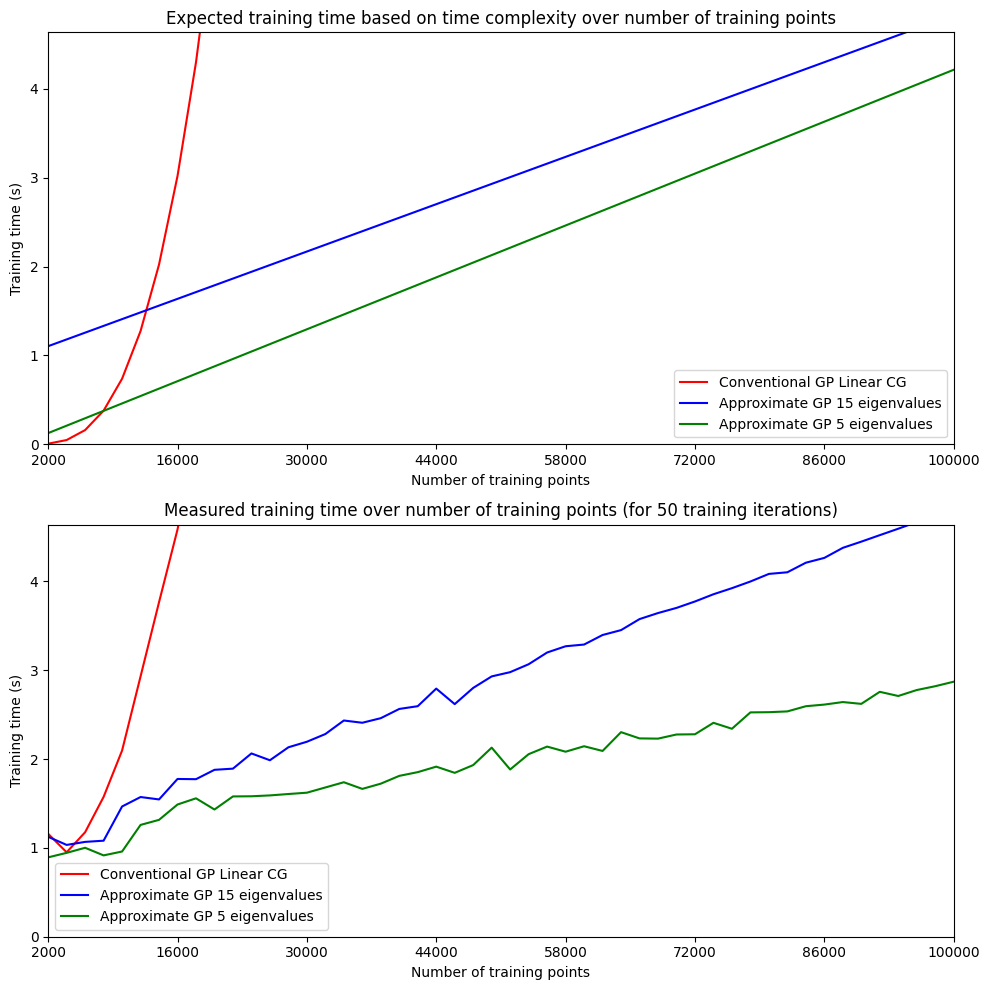

In [4]:
# plot results
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = max(np.nanmax(train_t[2:]), np.max(expected_train_t[2:]))

ax1.set_title("Expected training time based on time complexity over number of training points")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Training time (s)")

ax1.plot(sample_nbs, expected_train_t[0], 'r')
ax1.plot(sample_nbs, expected_train_t[1], 'b')
ax1.plot(sample_nbs, expected_train_t[2], 'g')

ax1.set_ylim(0, y_max + y_max / 10)
ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

# plot training time
ax2.set_title("Measured training time over number of training points (for 50 training iterations)")
ax2.set_xlabel("Number of training points")
ax2.set_ylabel("Training time (s)")

ax2.plot(sample_nbs, train_t[0], 'r')
ax2.plot(sample_nbs, train_t[1], 'b')
ax2.plot(sample_nbs, train_t[2], 'g')

ax2.set_ylim(0, y_max + y_max / 10)
ax2.set_xlim(x_min, x_max)
ax2.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax2.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()
plt.savefig(f"./temp/plots/time_complexity/single_approx.png")

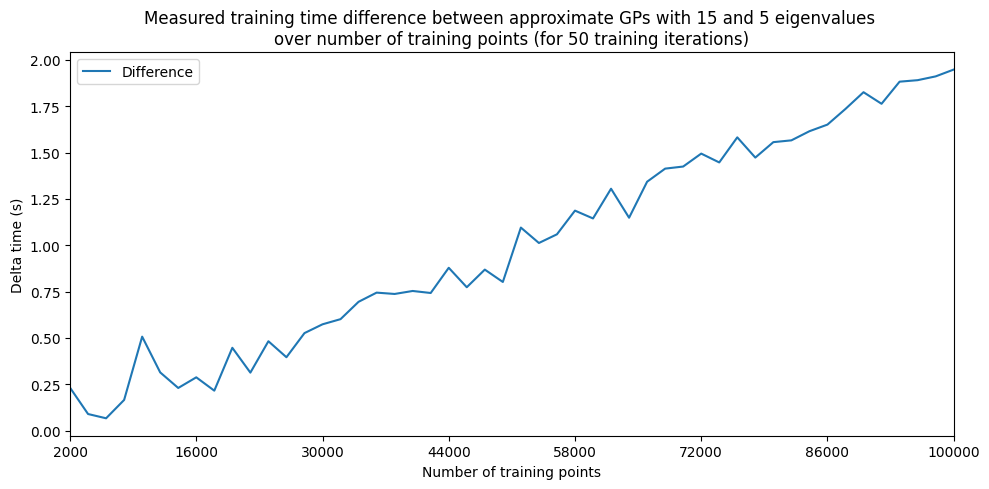

In [5]:
# plot difference between runtime of approx GPs wit 15 and 5 eigenvalues
train_diff = train_t[1] - train_t[2]

f, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)
y_max = np.nanmax(train_diff)

ax1.set_title("Measured training time difference between approximate GPs with 15 and 5 eigenvalues\nover number of training points (for 50 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("Delta time (s)")

ax1.plot(sample_nbs, train_diff)

ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Difference"])

f.tight_layout()
plt.savefig(f"./temp/plots/time_complexity/single_diff.png")

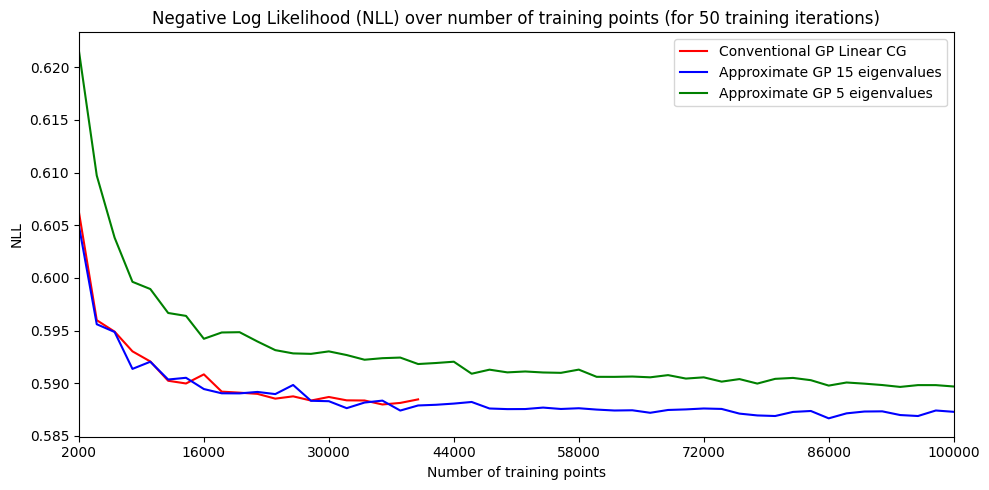

In [26]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_min, x_max = np.nanmin(sample_nbs), np.nanmax(sample_nbs)

# plot loss
ax1.set_title("Negative Log Likelihood (NLL) over number of training points (for 50 training iterations)")
ax1.set_xlabel("Number of training points")
ax1.set_ylabel("NLL")

ax1.plot(sample_nbs, train_l[0], 'r')
ax1.plot(sample_nbs, train_l[1], 'b')
ax1.plot(sample_nbs, train_l[2], 'g')

ax1.set_xlim(x_min, x_max)
ax1.set_xticks(np.arange(x_min, x_max + 1, 14000))
ax1.legend(["Conventional GP Linear CG", "Approximate GP 15 eigenvalues", "Approximate GP 5 eigenvalues"])

f.tight_layout()
plt.savefig(f"./temp/plots/time_complexity/single_nll.png")